In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
pool5 = np.load("MusicCNNFeatures/pool5.npy")

In [4]:
print(np.shape(pool5))

(400, 40, 128)


In [5]:
label_songs = pd.read_csv("./preprocessing/labels.csv")
info_songs = pd.read_csv("./Info/info.csv")

select_label = "genre"

if select_label == "genre":
    labels = label_songs[select_label].map({"classical":0, "electronic":1, "pop":2, "rock":3})
labels = labels.to_numpy()

In [6]:
n_data = len(label_songs)
idx = np.random.permutation(n_data)
info_songs = info_songs.reindex(idx)
pool5 = pool5[idx, :, :]
labels = labels[idx]

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

sample_size = (10, 128, 1)

drop_out_rate = 0.5

# very simple keras Sequential model
input_tensor = Input(sample_size)
x = layers.Conv2D(5, (10, 1), padding="valid", activation="relu", strides=1)(input_tensor)
#x = layers.MaxPooling2D(pool_size=(4,1))(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(4, activation="softmax")(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)

In [8]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 128, 5)         55        
_________________________________________________________________
dropout (Dropout)            (None, 1, 128, 5)         0         
_________________________________________________________________
dense (Dense)                (None, 1, 128, 20)        120       
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 10244 

In [9]:
def slice_accordingly(input_tensor, labels, size=10):

    input_shape = (tf.shape(input_tensor).numpy())
    
    input_shape[1] = size
    size = input_shape
    
    sliced_tensor = tf.image.random_crop(input_tensor, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

In [10]:
fraction_validation = 0.25
n_test = int(fraction_validation*len(labels))
n_train = len(labels) - n_test

train_features, train_labels = pool5[:n_train], labels[:n_train]
validation_features, validation_labels = pool5[n_train:], labels[n_train:]

print(n_test)

100


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))

In [12]:
model = model_1

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

n_epochs = 20
batch_size = 20

for epoch in range(n_epochs):
    print("Epoch", epoch)
    train_ds = train_dataset.shuffle(n_train).batch(batch_size)
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    for X, Y in train_ds:
        X, Y = slice_accordingly(X, Y)
        
        history = model.fit(X, Y,
                           validation_data=(x_val, y_val),
                           verbose=1) 

Epoch 0
1/1 [==============================] - 0s 82ms/step - loss: 1.2536 - accuracy: 0.6500 - val_loss: 1.1996 - val_accuracy: 0.5670
Epoch 1
1/1 [==============================] - 0s 87ms/step - loss: 0.9642 - accuracy: 0.7000 - val_loss: 0.9079 - val_accuracy: 0.6429
Epoch 2
1/1 [==============================] - 0s 83ms/step - loss: 0.8356 - accuracy: 0.5000 - val_loss: 0.7118 - val_accuracy: 0.6800
Epoch 3
1/1 [==============================] - 0s 82ms/step - loss: 0.5334 - accuracy: 0.8000 - val_loss: 0.5939 - val_accuracy: 0.7347
Epoch 4
1/1 [==============================] - 0s 88ms/step - loss: 0.6682 - accuracy: 0.7500 - val_loss: 0.5071 - val_accuracy: 0.7755
Epoch 5
1/1 [==============================] - 0s 83ms/step - loss: 0.5884 - accuracy: 0.7500 - val_loss: 0.5012 - val_accuracy: 0.7071
Epoch 6
1/1 [==============================] - 0s 66ms/step - loss: 0.4927 - accuracy: 0.9000 - val_loss: 0.5522 - val_accuracy: 0.7100
Epoch 7
1/1 [==============================] - 0

In [29]:
def slice(input_tensor, labels, begin, size=10):

    input_shape = (tf.shape(input_tensor).numpy())
    
    begin = [0, begin, 0]
    size = [100, size, 128]
    
    sliced_tensor = tf.slice(input_tensor, begin, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

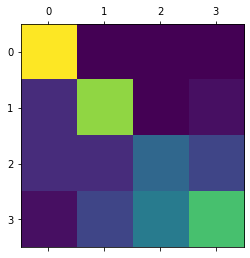

In [40]:
val_ds = validation_dataset.batch(n_test)

x_val, y_val = next(iter(val_ds))
x_val, y_val = slice(x_val, y_val, 0)

predictions = model.predict(x_val)
predictions = tf.argmax(predictions,1)

cm = tf.math.confusion_matrix(
    y_val, predictions, num_classes=4)

import matplotlib.pyplot as plt
plt.matshow(cm)